##GAN&CLIP&GA - CIFAR 10 EVALUATION - USING FINAL IMAGES

Authors: Maciej Domagała, Adam Komorowski

### GENERATING IMAGES

In [ ]:
#@title Initialization (Installation, Imports) - check github branch!
%%capture
import subprocess
import re

nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
version = re.findall("release (\d+\.\d+)", nvcc)[0]

pytorch_suffix = {
    "10.0": "+cu100",
    "10.1": "+cu101",
    "10.2": "",
}

pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

!git clone https://github.com/maciejdomagala/clip_gans.git
%cd clip_gans
!git checkout evaluation ### WARNING!!!

try:
  import torch
except:
  !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

try:
  import torchvision
except:
  !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

!pip install pytorch_pretrained_biggan pymoo kornia ftfy tensorboard

# IMPORTS
import warnings

import argparse
import os
import torch
import numpy as np
import pickle
import math
from tqdm import tqdm_notebook
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request
import cv2

from config import get_config
from problem import GenerationProblem
from operators import get_operators


warnings.filterwarnings('ignore')

In [ ]:
#@title Input Parameters (Code will produce (population_size*number_of_loops) evaluation images)
target = "cat" #@param ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
config = "DeepMindBigGAN256" #@param ["DeepMindBigGAN256", "DeepMindBigGAN512", "StyleGAN2_ffhq_nod", "StyleGAN2_car_nod", "StyleGAN2_church_nod"]
generations =  30#@param {type:"number"}
population_size = 64 #@param {type:"number"}
number_of_loops =  3#@param {type:"number"}
algorithm_param = 'ga' #@param ['ga', 'de']

In [ ]:
#@title Config 
config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    tmp_folder="./results"
)
vars(config).update(get_config(config.config))
config.pop_size = population_size
config.algorithm = algorithm_param
config.generations = generations

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)
if not os.path.exists(f'{config.tmp_folder}/{config.target}'): os.mkdir(f'{config.tmp_folder}/{config.target}')


In [ ]:
#@title Support methods

def save_callback(algorithm):
    global config, iteration, loop, target

    iteration += 1

    sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
    X = np.stack([p.X for p in sortedpop])      
    ls = config.latent(config)
    ls.set_from_population(X)

def generate_image(loop: int):
  problem = GenerationProblem(config)
  operators = get_operators(config)

  algorithm = get_algorithm(
      config.algorithm,
      pop_size=config.pop_size,
      sampling=operators["sampling"],
      crossover=operators["crossover"],
      mutation=operators["mutation"],
      eliminate_duplicates=True,
      callback=save_callback,
      **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
  )

  res = minimize(
      problem,
      algorithm,
      ("n_gen", config.generations),
      save_history=False,
      verbose=False,
  )
  
  X = np.atleast_2d(res.X) # for config.n_obj==1
  ls = config.latent(config)
  ls.set_from_population(X)

  with torch.no_grad():
      generated = problem.generator.generate(ls)
  print(f'Final image for "{config.target}" target - loop {loop}.')
  problem.generator.save(generated, f"./{config.tmp_folder}/{config.target}/loop_{loop}.jpg")
  display(Image(f"./{config.tmp_folder}/{config.target}/loop_{loop}.jpg"))

Final image for "cat" target - loop 0.


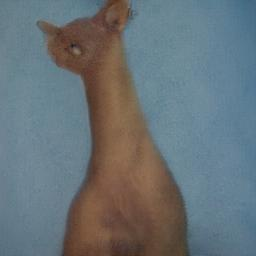

Final image for "cat" target - loop 1.


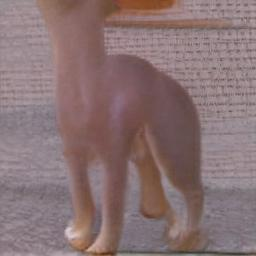

Final image for "cat" target - loop 2.


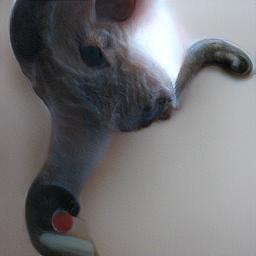

In [ ]:
#@title RUN (GENERATE IMAGES)


for loop in tqdm_notebook(range(number_of_loops)):
  iteration=0
  generate_image(loop)

### CIFAR10 - CLASS EVALUATION

In [ ]:
#@title Initialization
%%capture

%cd /content
!git clone https://github.com/vrakesh/CIFAR-10-Classifier
%cd CIFAR-10-Classifier/

from cifar_classifier import cifar_classifier
cc = cifar_classifier()
model = cc.get_model('cnn')
model.load_weights('cifar10.model.cnn.hdf5')
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
#@title RUN - EVALUATE CLASS
class_to_check = target
import PIL
list_of_images = []
for (dirpath, dirnames, filenames) in os.walk(f'/content/clip_gans/{config.tmp_folder[2:]}/{class_to_check}'):
    list_of_images += [os.path.join(dirpath, file) for file in filenames]

acc_count = 0
for image_path in tqdm_notebook(list_of_images):
  im = (PIL.Image.open(image_path))
  im = im.resize((32, 32))
  im = np.expand_dims(im, 0)
  y_hat = model.predict(im)
  predicted_label = cifar10_labels[np.argmax(y_hat[0])]
  if predicted_label==class_to_check:
    acc_count += 1
print(f'\nAccuracy for {class_to_check.upper()} class: {round(acc_count/len(list_of_images)*100, 2)}%, ({acc_count}/{len(list_of_images)})')
print(f'Number of evaluated images: {len(list_of_images)}')



Accuracy for CAT class: 33.33%, (1/3)
Number of evaluated images: 3
